# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
!wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv

--2024-05-11 21:15:41--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8829280 (8.4M) [text/plain]
Saving to: ‘tweets_coronavirus.csv’

tweets_coronavirus. 100%[===================>]   8.42M  --.-KB/s    in 0.1s    

2024-05-11 21:15:42 (70.3 MB/s) - ‘tweets_coronavirus.csv’ saved [8829280/8829280]



In [3]:
df = pd.read_csv("tweets_coronavirus.csv", encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
16507,23900,68852,Australia,24-03-2020,"COVID-19 is causing online sales to increase, ...",Positive
23865,32965,77917,MENA,05-04-2020,Countries that chosen (rightfully) to shut-dow...,Positive
21241,29700,74652,Liverpool,01-04-2020,Meet Alan Supermarket staff like him are worki...,Positive
18804,26688,71640,"San Francisco, CA",25-03-2020,As the world grapples with the devastating eff...,Extremely Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

Сбалансированы ли классы?

In [4]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if "Positive" in x else 0)
df.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
30613,41448,86400,NaN,10-04-2020,"@queenvic8940 Hello Vicki, we definitely under...",1
9566,15415,60367,NaN,20-03-2020,Walked to the grocery store to buy baby food. ...,0
31027,41974,86926,Bangladesh,11-04-2020,Sometimes common sense gets left behind by gee...,0
25694,35270,80222,NaN,06-04-2020,This corna shit is like the Salem witch trails...,0
9775,15668,60620,NY/NJ/Philly,20-03-2020,"I think the impact on retail, and specifically...",1
25123,34565,79517,"Dallas, TX",06-04-2020,"Workers at a Trader JoeÃÂs in New York, a Gi...",0
25785,35384,80336,"Fort Smith - Fayetteville, AR",07-04-2020,While continuing to serve the community throug...,0
2614,6960,51912,"Las Vegas, NV",18-03-2020,"Join me in giving a ""THANK YOU"" to grocery sto...",1
18208,25952,70904,"Round Rock, TX",25-03-2020,We are a family of 5 and I have made the bold ...,0
20528,28845,73797,"Loves Park, IL",29-03-2020,@Consumer_Cell has the worst customer service....,0


In [5]:
class_counts = df['Sentiment'].value_counts()
print(class_counts)

Sentiment
1    18046
0    15398
Name: count, dtype: int64


**Ответ:** # данные сбалансированы


Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [6]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [7]:
df.fillna('Unknown', inplace=True)
df.isnull().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('Sentiment', axis=1)
y = df['Sentiment']

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [9]:
from collections import Counter

tokens = train['OriginalTweet'].str.lower().str.split().sum()
token_counts = Counter(tokens)

Какой размер словаря получился?

In [10]:
dictionary_size = len(token_counts)
print(dictionary_size)

79755


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [11]:
top_10_tokens = token_counts.most_common(10)
top_10_tokens

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** # в топ попали предлоги, артикли, союзы, которые необходимы для построения предложений в английском языке и не несут в себе информациию Также в топ попал #coronavirus, так как это тема всех твитов

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [12]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
filtered_token_counts = {token: count for token, count in token_counts.items() if token not in stop_words}
top_10_tokens = Counter(filtered_token_counts).most_common(10)
top_10_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:**  # теперь в топе остался topic твитов, его синонимы и соответствующие обстановке при коронавирусе слова(то, чем нужно закупаться: еда, бакалея, то где:магазин, супермаркет и то, кого нужно опасаться: люди)

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [13]:
least_common_tokens = Counter(filtered_token_counts).most_common()[:-21:-1]
least_common_tokens

[('https://t.co/7j2y3rsld9', 1),
 ('@680news', 1),
 ('@torontopearson', 1),
 ('nothing...', 1),
 ('flew', 1),
 ('wage!', 1),
 ('renewing', 1),
 ('playersã\x82â\x92', 1),
 ('subsidise', 1),
 ('non-playing', 1),
 ('premiership', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('#southkerry', 1),
 ('#skelligcoast2kms', 1),
 ('@skelligsix18', 1),
 ('closer!)', 1),
 ('coast!', 1),
 ('skellig', 1)]

**Ответ:** # это опечатки, ссылки, не относящиеся напрямую к теме хештеги и слова



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [14]:
from nltk.tokenize import TweetTokenizer
from collections import Counter

tknzr = TweetTokenizer()
tokens = train['OriginalTweet'].apply(lambda x: tknzr.tokenize(x.lower())).sum()
token_counts = Counter(tokens)
top_10_tokens = token_counts.most_common(10)
print(top_10_tokens)

[('the', 26993), ('.', 24118), ('to', 23478), (',', 17571), ('and', 14825), ('of', 13044), ('a', 11891), ('in', 11348), ('?', 9524), ('#coronavirus', 8808)]


** Ответ:** # к словам добавились знаки препинания

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [15]:
from string import punctuation

stop_words = set(stopwords.words('english'))
punctuation = set(punctuation)
filtered_token_counts = {token: count for token, count in token_counts.items() if token not in stop_words and token not in punctuation}
top_10_tokens = Counter(filtered_token_counts).most_common(10)
top_10_tokens

[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

**Ответ:** # добавились новые символы

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [16]:
filtered_token_counts = {token: count for token, count in filtered_token_counts.items() if len(token) > 1 and all(ord(char) < 128 for char in token)}
top_10_tokens = Counter(filtered_token_counts).most_common(10)
print("Top 10 tokens:")
top_10_tokens

Top 10 tokens:


[('#coronavirus', 8808),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805),
 ('grocery', 3523),
 ('people', 3463),
 ('#covid19', 2589)]

In [17]:
least_common_tokens = Counter(filtered_token_counts).most_common()[:-21:-1]
print("Least common 20 tokens:")
least_common_tokens

Least common 20 tokens:


[('https://t.co/7j2y3rsld9', 1),
 ('@680news', 1),
 ('@torontopearson', 1),
 ('flew', 1),
 ('renewing', 1),
 ('subsidise', 1),
 ('non-playing', 1),
 ('premiership', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('#southkerry', 1),
 ('#skelligcoast2kms', 1),
 ('@skelligsix18', 1),
 ('skellig', 1),
 ('milion', 1),
 ('now.when', 1),
 ('https://t.co/5cbliqzx7l', 1),
 ('https://t.co/lw1r0rm7xs', 1),
 ('https://t.co/pd6ual9yfi', 1)]

**Ответ:** # топ популярных стал лучше, топ непопулярных хуже

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [18]:
hashtags = {token: count for token, count in filtered_token_counts.items() if token.startswith('#')}
top_10_hashtags = Counter(hashtags).most_common(10)
print("Top 10 hashtags:")
top_10_hashtags

Top 10 hashtags:


[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]



**Ответ:** # хештеги только о topic всех твитов - о коронавирусе

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [19]:
links = {token: count for token, count in filtered_token_counts.items() if token.startswith('https://t.co')}
top_10_links = Counter(links).most_common(10)
print("Top 10 links:")
top_10_links

Top 10 links:


[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3),
 ('https://t.co/aziqcdgrnn', 3)]

**Ответ:** # популярность ссылок в разы меньше, чем у хештегов. Информация о ссылках была бы полезной

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [20]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string

def custom_tokenizer(text):
    tknzr = TweetTokenizer()
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    text = text.lower()
    tokens = tknzr.tokenize(text)
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation and len(token) > 1 and all(ord(char) < 128 for char in token) and not token.startswith('https://t.co')]

    return tokens

In [21]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


44104


**Ответ:** # -- YOUR ANSWER HERE --

Посмотрим на какой-нибудь конкретный твитт:

In [23]:
ind = 9023
text = train.iloc[ind]['OriginalTweet']
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [24]:
vector = cv.transform([text])

non_zero_indices = vector.nonzero()[1]

non_zero_values = vector.data
print(non_zero_values)

max_index = non_zero_indices[non_zero_values.argmax()]
min_index = non_zero_indices[non_zero_values.argmin()]

tokens = cv.get_feature_names_out()
max_token = tokens[max_index]
min_token = tokens[min_index]

print("Most important token: ", max_token)
print("Least important token: ", min_token)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Most important token:  #coronavirusoutbreak
Least important token:  #coronavirusoutbreak


**Ответ:** # все токены повторяются по 1 разу

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf_vector = tfidf.fit_transform(train['OriginalTweet'])

tfidf_vector_text = tfidf.transform([text])

non_zero_indices = tfidf_vector_text.nonzero()[1]

non_zero_values = tfidf_vector_text.data

max_index = non_zero_indices[non_zero_values.argmax()]
min_index = non_zero_indices[non_zero_values.argmin()]

tokens = tfidf.get_feature_names_out()
max_token = tokens[max_index]
min_token = tokens[min_index]

print("Most important token: ", max_token)
print("Least important token: ", min_token)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Most important token:  brainless
Least important token:  food


**Ответ:** # поменялись... важный токен определился нормально: brainless - причина проблемы, неважный странновато, ведь food - тоже важное слово в твите

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [27]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4583,9362,54314,"Moulton, England",19-03-2020,Hearing so many stories of NHS heroes Teachers...,1
8221,13787,58739,Unknown,20-03-2020,Let s just take a minute to say THANK YOU also...,1
3183,7654,52606,"London, England",18-03-2020,"Back at the ""Frontline""\r\r\nA massive shout o...",1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
3281,7772,52724,"Nairobi, Kenya",18-03-2020,Crisp clean fresh air perfect ambience Covid 1...,1
...,...,...,...,...,...,...
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1


In [61]:
ind2 = 11636

In [62]:
train.iloc[ind2]['OriginalTweet'], train.iloc[ind2]['Sentiment']

(".@PLSBC answers legal questions related to COVID-19's impact on work, finances, consumer &amp; small business problems online at   https://t.co/GsKBUVeR6Z",
 0)

In [63]:
text = train.iloc[ind2]['OriginalTweet']

In [64]:
tfidf_vector_text = tfidf.transform([text])

non_zero_indices = tfidf_vector_text.nonzero()[1]
non_zero_values = tfidf_vector_text.data
max_index = non_zero_indices[non_zero_values.argmax()]
min_index = non_zero_indices[non_zero_values.argmin()]

tokens = tfidf.get_feature_names_out()
max_token = tokens[max_index]
min_token = tokens[min_index]

print("Most important token: ", max_token)
print("Least important token: ", min_token)

Most important token:  @plsbc
Least important token:  19


## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [65]:
texts = train['OriginalTweet']
y = train['Sentiment']

cv_matrix = cv.fit_transform(texts)
tfidf_matrix = tfidf.fit_transform(texts)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_cv = LogisticRegression()
lr_cv.fit(cv_matrix, y)

lr_tfidf = LogisticRegression()
lr_tfidf.fit(tfidf_matrix, y)

train_accuracy_cv = accuracy_score(y, lr_cv.predict(cv_matrix))
train_accuracy_tfidf = accuracy_score(y, lr_tfidf.predict(tfidf_matrix))

cv_test = cv.transform(test['OriginalTweet'])
tfidf_test = tfidf.transform(test['OriginalTweet'])
test_accuracy_cv = accuracy_score(test['Sentiment'], lr_cv.predict(cv_test))
test_accuracy_tfidf = accuracy_score(test['Sentiment'], lr_tfidf.predict(tfidf_test))

print("CountVectorizer train accuracy:", train_accuracy_cv)
print("CountVectorizer test accuracy:", test_accuracy_cv)
print("TfidfVectorizer train accuracy:", train_accuracy_tfidf)
print("TfidfVectorizer test accuracy:", test_accuracy_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

CountVectorizer train accuracy: 0.9839384878257155
CountVectorizer test accuracy: 0.866254733904724
TfidfVectorizer train accuracy: 0.9256300726185391
TfidfVectorizer test accuracy: 0.8535977675901933


**Ответ:** # лучшим стал CountVectorizer, модели классные

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [67]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from string import punctuation

def custom_stem_tokenizer(text):
    stemmer = SnowballStemmer('english')
    tokenizer = TweetTokenizer()
    stop_words = set(stopwords.words('english'))
    tokens = tokenizer.tokenize(text.lower())
    tokens = [
        stemmer.stem(token)
        for token in tokens
        if token not in stop_words
        and token not in punctuation
        and not token.startswith('https://t.co')
        and not(len(token) == 1 and (ord(token) >= 128))
    ]

    return tokens

In [68]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [69]:
cv_stem = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv_stem_matrix = cv_stem.fit_transform(texts)
print("CountVectorizer vocabulary size:", len(cv_stem.vocabulary_))

tfidf_stem = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tfidf_stem_matrix = tfidf_stem.fit_transform(texts)
print("TfidfVectorizer vocabulary size:", len(tfidf_stem.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer vocabulary size: 36652
TfidfVectorizer vocabulary size: 36652


**Ответ** # уменьшился

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [70]:
lr_cv = LogisticRegression()
lr_cv.fit(cv_stem_matrix, y)

lr_tfidf = LogisticRegression()
lr_tfidf.fit(tfidf_stem_matrix, y)

train_accuracy_cv = accuracy_score(y, lr_cv.predict(cv_stem_matrix))
train_accuracy_tfidf = accuracy_score(y, lr_tfidf.predict(tfidf_stem_matrix))

cv_test = cv_stem.transform(test['OriginalTweet'])
tfidf_test = tfidf_stem.transform(test['OriginalTweet'])
test_accuracy_cv = accuracy_score(test['Sentiment'], lr_cv.predict(cv_test))
test_accuracy_tfidf = accuracy_score(test['Sentiment'], lr_tfidf.predict(tfidf_test))

print("CountVectorizer train accuracy:", train_accuracy_cv)
print("CountVectorizer test accuracy:", test_accuracy_cv)
print("TfidfVectorizer train accuracy:", train_accuracy_tfidf)
print("TfidfVectorizer test accuracy:", test_accuracy_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CountVectorizer train accuracy: 0.9717642033319095
CountVectorizer test accuracy: 0.8674506677297189
TfidfVectorizer train accuracy: 0.9158906450234943
TfidfVectorizer test accuracy: 0.8560892963922663


**Ответ:** # качество на тестовой выборке увеличилось, но совсем незначительно. Использовать stem не было необходимости

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [88]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=0.31
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36651


In [89]:
train_cf_df = cv_df.fit_transform(train['OriginalTweet'])
test_cf_df = cv_df.transform(test['OriginalTweet'])

lr_cv_df = LogisticRegression()
lr_cv_df.fit(train_cf_df, y)
print("CountVectorizer(max_df) test accuracy:", accuracy_score(test['Sentiment'], lr_cv_df.predict(test_cf_df)))

CountVectorizer(max_df) test accuracy: 0.8681482957942994


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Ответ:** # CountVectorizer(max_df) test accuracy: 0.8681482957942994


Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [97]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train['OriginalTweet']
                            )
len(cv_df.vocabulary_)

3700

In [105]:
train_cf_df = cv_df.fit_transform(train['OriginalTweet'])
test_cf_df = cv_df.transform(test['OriginalTweet'])

lr_cv_df = LogisticRegression()
lr_cv_df.fit(train_cf_df, y)
print("CountVectorizer(min_df) test accuracy:", accuracy_score(test['Sentiment'], lr_cv_df.predict(test_cf_df)))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(min_df) test accuracy: 0.8677496511859677


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Ответ:** # CountVectorizer(min_df) test accuracy: 0.8677496511859677

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [106]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler(with_mean=False)
train_cv_sc = sc.fit_transform(train_cf_df)
test_cv_sc = sc.transform(test_cf_df)
lr_cv_sc = LogisticRegression()
lr_cv_sc.fit(train_cv_sc, y)
print("CountVectorizer(min_df_sc) test accuracy:", accuracy_score(test['Sentiment'], lr_cv_sc.predict(test_cv_sc)))

CountVectorizer(min_df_sc) test accuracy: 0.8447279250548136


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


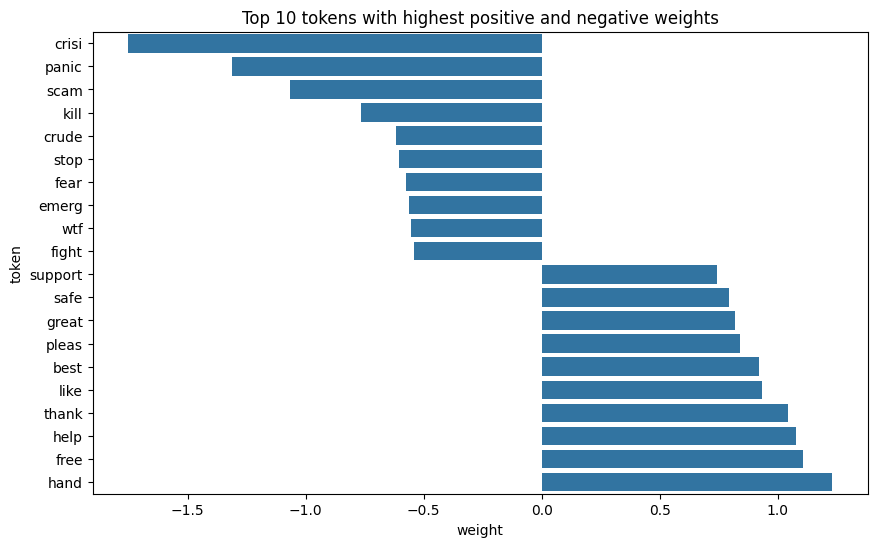

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

top_positive_tokens = tokens_weights[tokens_weights.weight > 0].head(10)
top_negative_tokens = tokens_weights[tokens_weights.weight < 0].head(10)
top_tokens = pd.concat([top_positive_tokens, top_negative_tokens])

top_tokens = top_tokens.sort_values(by='weight')

plt.figure(figsize=(10, 6))
sns.barplot(x='weight', y='token', data=top_tokens)
plt.title('Top 10 tokens with highest positive and negative weights')
plt.show()

**Ответ:** # на графике видим, что с положительными весами стоят токены положительного окраса, с отрицательными весами - негативного

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [112]:
print("Unique values in 'UserName': ", df['UserName'].nunique())
print("Unique values in 'ScreenName': ", df['ScreenName'].nunique())
print("\nValue counts for 'UserName':\n", df['UserName'].value_counts())
print("\nValue counts for 'ScreenName':\n", df['ScreenName'].value_counts())

Unique values in 'UserName':  33444
Unique values in 'ScreenName':  33444

Value counts for 'UserName':
 UserName
3800     1
31051    1
31049    1
31047    1
31046    1
        ..
17320    1
17319    1
17318    1
17317    1
44955    1
Name: count, Length: 33444, dtype: int64

Value counts for 'ScreenName':
 ScreenName
48752    1
76003    1
76001    1
75999    1
75998    1
        ..
62272    1
62271    1
62270    1
62269    1
89907    1
Name: count, Length: 33444, dtype: int64


**Ответ:** # все элементы уникальны, смысла кодировать нет

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

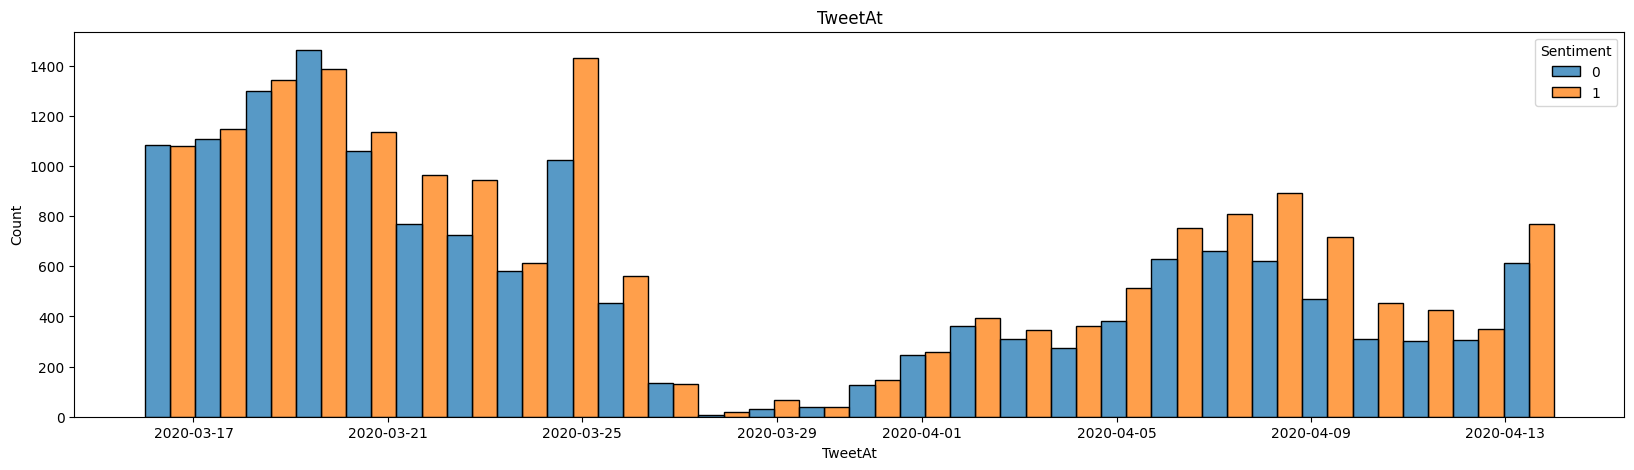

In [128]:
plt.figure(figsize=(20,5))
plt.title("TweetAt")
sns.histplot(data=df, hue='Sentiment', x = 'TweetAt', multiple="dodge")
plt.show()

**Ответ:** # количество твитов с противоположными окрасками почти в каждую дату совпадают, что говорит о том, что этот признак бесполезен



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [129]:
unique_locations = df['Location'].nunique()
print("Unique values in 'Location': ", unique_locations)

Unique values in 'Location':  10465


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

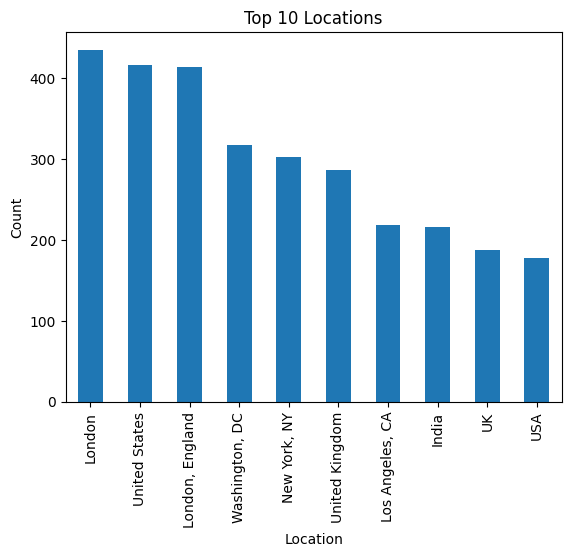

In [130]:
top_locations = df[df['Location'] != 'Unknown']['Location'].value_counts().head(10)
top_locations.plot(kind='bar')
plt.title('Top 10 Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [131]:
df['WiderLocation'] = df['Location'].apply(lambda x: x.split(',')[-1].strip() if ',' in x else x)

unique_wider_locations = df['WiderLocation'].nunique()
print("Unique values in 'WiderLocation': ", unique_wider_locations)

Unique values in 'WiderLocation':  6305


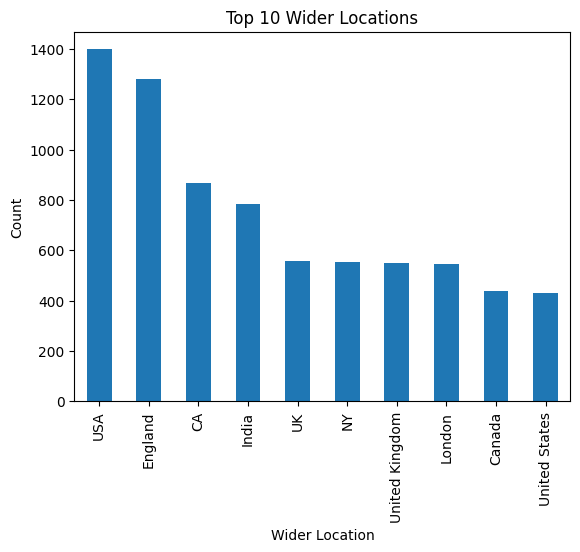

In [132]:
top_wider_locations = df[df['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts().head(10)
top_wider_locations.plot(kind='bar')
plt.title('Top 10 Wider Locations')
plt.xlabel('Wider Location')
plt.ylabel('Count')
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [133]:
locations_more_than_once = df['WiderLocation'].value_counts()[df['WiderLocation'].value_counts() > 1].index
df_encoded = pd.get_dummies(df[df['WiderLocation'].isin(locations_more_than_once)]['WiderLocation'])

unique_encoded_locations = df_encoded.shape[1]
print("Unique encoded values in 'WiderLocation': ", unique_encoded_locations)

Unique encoded values in 'WiderLocation':  1335


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [140]:
from scipy.sparse import hstack

train, test = train_test_split(df, test_size=0.3, random_state=0)

cv = CountVectorizer()
train_cv = cv.fit_transform(train['OriginalTweet'])
test_cv = cv.transform(test['OriginalTweet'])
sc = StandardScaler(with_mean=False)
train_cv_sc = sc.fit_transform(train_cv)
test_cv_sc = sc.transform(test_cv)

encoder = OneHotEncoder(categories='auto')
train_new_feature_encoded = encoder.fit_transform(train['WiderLocation'].values.reshape(-1, 1))
test_new_feature_encoded = encoder.transform(test['WiderLocation'].values.reshape(-1, 1))
train_cv_sc_with_new_feature = hstack([train_cv_sc, train_new_feature_encoded])
test_cv_sc_with_new_feature = hstack([test_cv_sc, test_new_feature_encoded])

lr_with_new_feature = LogisticRegression()
lr_with_new_feature.fit(train_cv_sc_with_new_feature, train['Sentiment'])

print("Accuracy with new feature:", accuracy_score(test['Sentiment'], lr_with_new_feature.predict(test_cv_sc_with_new_feature)))

Accuracy with new feature: 0.7864261510863065


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Ответ:** # не особо

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

увы